# Protocol: Improving State Space Coverage using Start Overs

Date: 17.09.2021

## Question

Do *Start Overs* increase the State Space Coverage Growth and thus the model checking performance?

## Hypothesis

The basic BFS search terminates as soon as all successors are already visited according to the hash table. Thus, the maximum BFS depth is determined by the hash table's capacity. Also, each VT again starts at the initial state, resulting in all VTs potentially only exploring the tip of a model.

By continuing the BFS within a VT using the set of last unvisited successors, we can reach deeper states of the model. By exploring deeper states, we expect to discover more violations and thus a faster growing state space coverage.

## Setup

- GPU: NVIDIA GeForce RTX 2080 Ti
- Program: `main` branch, commit e160572
- Model: Waypoints model
- CUDA_FLAGS: `-DGRAPPLE_MODEL=WaypointsState`

## Implementation

First, we compile with the additional CUDA_FLAGS `-DGRAPPLE_HT=18 -DGRAPPLE_SO=0` (the default parameters).

```
$ time ./build/grapple -s 1736331306 -n 1000
...

real    7m22.195s
user    7m21.844s
sys     0m0.296s
```

Full output data is available at [EXP-04-start-overs-1.csv](./data/EXP-04-start-overs-1.csv).

---

For the second experiment, we compile with the additional CUDA_FLAGS `-DGRAPPLE_HT=14 -DGRAPPLE_SO=15`.

14 is an arbitrary, but much lower hash table capacity: HT 18 results in 262144 hash table slots, HT 14 in 16384. As HT 14 fits only $\frac{1}{16}$ the states, we add 15 start overs, resulting in 16 searches, including the initial search.

```
$ time ./build/grapple -s 1736331306 -n 1000

real    4m2.999s
user    4m2.684s
sys     0m0.260s
```

Full output data is available at [EXP-04-start-overs-2.csv](./data/EXP-04-start-overs-2.csv).

## Evaluation

First, we plot the discovered violations in relation to the number of executed VTs for both experiments.

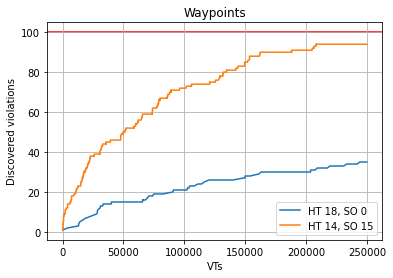

In [2]:
import pandas as pd

data1 = pd.read_csv("./data/EXP-04-start-overs-1.csv", skipinitialspace=True)
data2 = pd.read_csv("./data/EXP-04-start-overs-2.csv", skipinitialspace=True)

pp = data1[pd.notnull(data1["state"])].plot(x="vts", xlabel="VTs", y="uniques", ylabel="Discovered violations", grid=True, legend=False, title="Waypoints")
data2[pd.notnull(data2["state"])].plot(ax=pp, x="vts", xlabel="VTs", y="uniques", ylabel="Discovered violations", grid=True, legend=False)
pp.legend([
    "HT 18, SO 0",
    "HT 14, SO 15"
])
pp.axhline(y=100, color="red", zorder=0)

pp.get_figure().savefig("output-assets/EXP-04-start-overs-1.pdf")

For comparison with other models (see [EXP-13](EXP-13-start-overs-low-connectivity.ipynb)), we also plot the unique states visited in relation to the number of executed VTs.

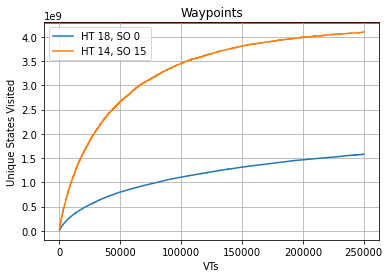

In [3]:
pp = data1.plot(x="vts", xlabel="VTs", y="visited", ylabel="Unique States Visited", grid=True, legend=False, title="Waypoints")
data2.plot(ax=pp, x="vts", xlabel="VTs", y="visited", ylabel="Unique States Visited", grid=True, legend=False)
pp.legend([
    "HT 18, SO 0",
    "HT 14, SO 15"
])
pp.axhline(y=2**32, color="red", zorder=0)

pp.get_figure().savefig("output-assets/EXP-04-start-overs-2.pdf")

As the number of total visited states by a VT varies due to different hash collisions etc., we also compare the cumulated number of total visited states of both experiments.

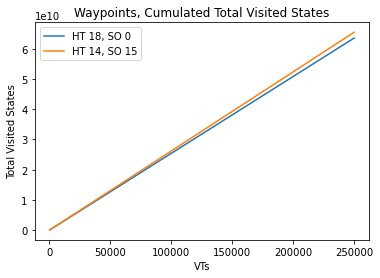

In [4]:
data1["total_visited_cumsum"] = data1[pd.isnull(data1["state"])]["total_visited"].cumsum()
data2["total_visited_cumsum"] = data2[pd.isnull(data2["state"])]["total_visited"].cumsum()

pp = data1[pd.isnull(data1["state"])].plot(x="vts", y="total_visited_cumsum", ylabel="Total Visited States", title="Waypoints, Cumulated Total Visited States")
data2[pd.isnull(data2["state"])].plot(x="vts", y="total_visited_cumsum", xlabel="VTs", ax=pp)
pp.legend([
    "HT 18, SO 0",
    "HT 14, SO 15"
])

pp.get_figure().savefig("output-assets/EXP-04-start-overs-3.pdf")

## Conclusion, Discussion

The HT 14 SO 15 experiment has shown that the start over strategy results in a signifcant increase of discovered violations on a similar number of visited states. At the same time, execution time is 1.82x faster with the start over strategy.

Thus, our hypothesis can be confirmed on the Waypoints model with the provided build parameters.